# Lab assignment: detecting toxic comments with Deep Learning

<img src="img/trolling.gif" style="width:600px;">

In this assignment we will analyze text comments appearing in social media, trying to automatically detect those of toxic content: insults, threats, obscene comments, ... to do so we will make use of word embeddings and convolutional and recurrent neural networks.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary exercise that can help you gain a deeper knowledge into the topic. Good luck!</td></tr>
</table>

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Deep Learning environment files](https://github.com/albarji/teaching-environments/tree/master/deeplearning).

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## The Keras library

In this lab we will make use of the [keras](http://keras.io/) Deep Learning library for Python. This library allows building several kinds of shallow and deep networks, following either a sequential or a graph architecture.

## Data loading

Data is provided as two separate files, one with texts for training the model and another one for testing. Both files are available in compressed form under the *data* folder.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Load the data into two <a href=https://pandas.pydata.org/>pandas</a> Dataframes, <b>train</b> for the training data and <b>test</b> for the test data.
 </td></tr>
</table>

In [2]:
####### INSERT YOUR CODE HERE
import pandas as pd
train = pd.read_csv("data/toxic_train.csv.zip", index_col="id")
test = pd.read_csv("data/toxic_test.csv.zip", index_col="id")

If you have loaded the data properly, you should be able to visualize the first rows of each data set as follows

In [3]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
e0fdfd98c66fb643,"""\n\n Huggle not working \n\nHi Gurch. There i...",0,0,0,0,0,0
1864753b5fb6c9a3,Mossad actually. I know where you live.,0,0,0,0,0,0
ce1db53fb22d399c,REDIRECT Talk:UFC Fight Night: Belfort vs. Hen...,0,0,0,0,0,0
fed4f08d59399398,"""\n\nUPA IRC\nWhat about 19:00 UTC? e | ταλκ """,0,0,0,0,0,0
06e7f93938ad9e72,"""\nI've re-added your information, together wi...",0,0,0,0,0,0


In [4]:
test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
dd2dcd01f0536e53,"""\nEdit: Please stated the basis for your acc...",0,0,0,0,0,0
b20b1e8381e306f8,Wikipedia is a repetition of the old joke that...,0,0,0,0,0,0
54a933831401b9b2,And the same in Serbian:ђе and Croatian:če and...,0,0,0,0,0,0
e7a4575dba88d9f3,"""\n\n Congrats... You gave an awesome answer i...",0,0,0,0,0,0
452d5cc2ccd1d611,Wiki users controlling information \n\nDeliber...,0,0,0,0,0,0


As you can see, the data files include a column *comment_text* with the text we must classify, and 6 additional columns with the kinds of toxicity that might be present in a comment: *toxic*, *severe_toxic*, *obscene*, *threat*, *insult* and *identity_hate*.

## Data processing

We can't introduce text directly into the network, so we will have to tranform it to a vector representation. To do so, we will first **tokenize** the text into words (or tokens), and assign a unique identifier to each word found in the text. Doing this will allow us to perform the encoding. We can do this easily by making use of the **Tokenizer** class in keras:

In [5]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


A Tokenizer offers convenient methods to split texts down to tokens. At construction time we need to supply the Tokenizer the maximum number of different words we are willing to represent. If our texts have greater word variety than this number, the least frequent words will be discarded. We will choose a number large enough for our purpose.

In [6]:
maxwords = 15000
tokenizer = Tokenizer(num_words = maxwords)

We now need to **fit** the Tokenizer to the training texts, which can be done as follows:

In [7]:
tokenizer.fit_on_texts(train["comment_text"])

After fitting the Tokenizer we can see a report of the number of times each word has been found in the input texts.

In [8]:
tokenizer.word_counts

OrderedDict([('huggle', 51),
             ('not', 70441),
             ('working', 1506),
             ('hi', 5976),
             ('gurch', 16),
             ('there', 23945),
             ('is', 132304),
             ('a', 162211),
             ('discussion', 6812),
             ('over', 6172),
             ('at', 29842),
             ('wp', 8058),
             ('hg', 11),
             ('f', 1095),
             ('regarding', 2274),
             ('something', 5549),
             ('that', 116212),
             ('has', 23136),
             ('gone', 735),
             ('wrong', 3967),
             ('with', 44830),
             ('preventing', 78),
             ('us', 4617),
             ('from', 31088),
             ('using', 4615),
             ('it', 97688),
             ('if', 44113),
             ('you', 155213),
             ('have', 54392),
             ('any', 18814),
             ('ideas', 692),
             ('or', 40131),
             ('suggestions', 564),
             ('might', 4

Now the we have trained the tokenizer we can use it to vectorize the texts. In particular, we would like to transform the texts to sequences of word indexes. We can do this through the **text_to_sequences** method

In [9]:
X_train = tokenizer.texts_to_sequences(train["comment_text"])

We can see now how a text has been transformed to a list of word indexes.

In [10]:
X_train[0]

[8034,
 14,
 619,
 158,
 41,
 8,
 5,
 136,
 152,
 34,
 116,
 820,
 425,
 168,
 9,
 43,
 1158,
 238,
 21,
 6162,
 202,
 32,
 204,
 11,
 22,
 6,
 19,
 55,
 1208,
 25,
 1463,
 6,
 188,
 106,
 2,
 5909,
 10,
 64,
 94,
 344,
 4683]

What do these indexes mean? Each number represents a word recognized by the trained Tokenizer. To check what word each index represents, we can take a look at the **word_index** attribute:

In [11]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'are': 18,
 'have': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'by': 31,
 'from': 32,
 'do': 33,
 'at': 34,
 'about': 35,
 'me': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'just': 49,
 'like': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'been': 54,
 'any': 55,
 'should': 56,
 'we': 57,
 'more': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'see': 63,
 'here': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'am': 71,
 'edit': 72,
 "i'm": 73,
 'people': 74,
 'up': 75,
 'why': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

As usual, we will need to repeat this transformation to indexes for the test data.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Repeat the transformation to sequences of indexes for the test data. Save the result of the transformation into an <b>X_test</b> variable..
 </td></tr>
</table>

In [12]:
####### INSERT YOUR CODE HERE
X_test = tokenizer.texts_to_sequences(test["comment_text"])

This is enough to train a Sequential Network. However, for efficiency reasons it is recommended that all sequences in the data have the same number of elements. Since this is not the case for our data, as each text has a different number of words, we should **pad** the sequences to ensure the same length. The padding procedure adds a special *null* symbol to short sequences, and clips out parts of long sequences, thus enforcing a common size.

This procedure can be performed easily by again resorting to keras tools. To choose an appropriate padding length we can have a look at a boxplot of the number of tokens in our training texts.

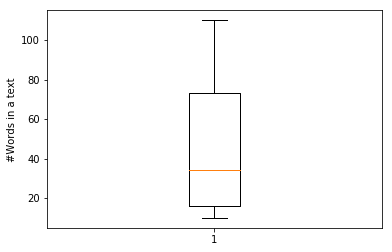

In [13]:
import matplotlib.pyplot as plt

plt.boxplot([len(text) for text in X_train], whis=[15, 85], showfliers=False)
plt.ylabel("#Words in a text")
plt.show()

We will pad all sequences to have a maximum of 120 indexes (words), which is enough to represent 85% of our texts without dropping tokens.

In [14]:
from keras.preprocessing.sequence import pad_sequences 
maxsequence = 120
X_train = pad_sequences(X_train, maxlen=maxsequence)

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Repeat the process for the test data, saving the result into a variable <b>X_test</b>.
 </td></tr>
</table>

In [15]:
####### INSERT YOUR CODE HERE
X_test = pad_sequences(X_test, maxlen=maxsequence)

The texts are now ready to serve as inputs for the model. We must also process the toxicity labels to serve as outputs. To do so, just create Dataframe or numpy arrays **y_train** and **y_test** containing the 6 columns with the toxicity indicators.

In [16]:
####### INSERT YOUR CODE HERE
y_train = train.drop("comment_text", axis=1).values
y_test = test.drop("comment_text", axis=1).values

## Continuous Bag of Words model (CBoW)

<img src="img/CBoW.png" style="width:800px;">

We will start with a simple, yet effective model to deal with sequences of words: the Continuous Bag of Words (CBoW) model. This model is comprised of:

* An [Embedding](https://keras.io/layers/embeddings/) layer that transforms word indexes to a vector representation that is learned with the model. 
* A  **GlobalAveragePooling1D** layer that obtains a representation of the whole document as the average of all its word vector representations
* A final layer taking the decision of the network.

Let's start by creating a keras Sequential model

In [17]:
from keras.models import Sequential

model = Sequential()

The first layer in a network that works with indexes should be the Embedding layer. We will transform each index (word) into an embedding vector of 64 elements, which will be learned by the network. This can be done as

In [18]:
from keras.layers.embeddings import Embedding

model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))

Note how the Embedding layer requires three parameters: the number of different words in our problem (input_dim), the length of the input sequences (input_length) and the size of the embedding vectors to be created (output_dim).

After the embedding we will add the averaging layer to obtain a single vector of values representing the whole document.

In [19]:
from keras.layers import GlobalAveragePooling1D

model.add(GlobalAveragePooling1D())

After this we will add the output layer. The problem we are trying to solve is a **multilabel** problem: there are 6 possible toxic classes for each text, but a text might include several of these classes, or none of them. Therefore, the output layer should contain 6 neurons followed by a sigmoid activation. This way each class might activate independently of the rest.

In [20]:
from keras.layers.core import Dense, Activation

model.add(Dense(6))
model.add(Activation('sigmoid'))

And with this the design of the CBoW is finished! Let's check what we have built

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           960000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
_________________________________________________________________
activation_1 (Activation)    (None, 6)                 0         
Total params: 960,390
Trainable params: 960,390
Non-trainable params: 0
_________________________________________________________________


Note how most of the model parameters are located in the Embedding layer. That is, the focus of the network is on finding good word representations that allow classifying the sentiment of the sentence.

We now follow the usual procedure for compiling the network. Note that since we have a multiple but independent output neurons, we select **binary_crossentropy** as the network loss.

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

And we proceed on to train the network. Since the CBoW model is very simple, training should be reasonably fast.

In [23]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
119678/119678 [==============================] - 21s 174us/step - loss: 0.1319 - acc: 0.9635
Epoch 2/10
119678/119678 [==============================] - 14s 119us/step - loss: 0.0881 - acc: 0.9694
Epoch 3/10
119678/119678 [==============================] - 15s 122us/step - loss: 0.0750 - acc: 0.9749
Epoch 4/10
119678/119678 [==============================] - 14s 121us/step - loss: 0.0674 - acc: 0.9779
Epoch 5/10
119678/119678 [==============================] - 15s 129us/step - loss: 0.0627 - acc: 0.9797
Epoch 6/10
119678/119678 [==============================] - 15s 129us/step - loss: 0.0592 - acc: 0.9808
Epoch 7/10
119678/119678 [==============================] - 17s 139us/step - loss: 0.0566 - acc: 0.9815
Epoch 8/10
119678/119678 [==============================] - 17s 142us/step - loss: 0.0541 - acc: 0.9823
Epoch 9/10
119678/119678 [==============================] - 21s 171us/step - loss: 0.0520 - acc: 0.9828
Epoch 10/10
119678/119678 [==============================] - 19s

After training we can measure the performance over the test set as usual

In [24]:
score = model.evaluate(X_test, y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

39893/39893 [==============================] - 2s 54us/step
Test loss 0.07346271173992797
Test accuracy 0.9794617149619075


Note however that accuracy might not be the best metric for this problem: fortunately most of the comments in social media are not toxic, and so it's easy to obtain good accuracy by just classifying everything as non-toxic. In this kind of unbalanced problems it is better to make use of the [ROC AUC score](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [25]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

AUC score 0.9477635620452846


## Convolutional mixing model

Using the average of word embeddings is not optimal, since we are throwing away information about word ordering. A simple method to take neighborhoods of words into account is to add a small convolutional layer after the Embeddings layer. This way the embeddings of each word gets mixed with the embeddings of their neighbouring words, thus producing a more contextualized representation.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create a new model that follows the same architecture as the CBoW model above, but including a <a href="https://keras.io/layers/convolutional/">1-dimensional convolution</a> between the Embedding and the GlobalAveragePooling1D layers. You can use 64 filters with kernel size 9: this will mix the embeddings of length 64 of each word into new embeddings again of size 64, that now contain also information from close words. Try also with a small number of epochs, in the range 1-3. Do you obtain better results with this model?
 </td></tr>
</table>

In [47]:
####### INSERT YOUR CODE HERE
from keras.layers.convolutional import Conv1D

model = Sequential()
model.add(Embedding(maxwords, 64, input_length=maxsequence))
model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 64)           960000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 64)           36928     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
_________________________________________________________________
activation_8 (Activation)    (None, 6)                 0         
Total params: 997,318
Trainable params: 997,318
Non-trainable params: 0
_________________________________________________________________
Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 22s 185us/step - loss: 0.0

## LSTM model

<img src="img/LSTM.png" style="width:600px;">

Even if a simple convolutional mixing of neighbouring words might help, we are still missing something important. Language makes use of relationships between distant words to produce meaningful sentences, and we will need to make use of a more powerful mixing model to improve our results. To do so, we will make use of a Long-short Term Memory layer.

An LSTM layer that creates a document-level representation as a vector of 32 values can be created with Keras as follows 

In [27]:
from keras.layers.recurrent import LSTM

lstm_layer = LSTM(32)

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     If you are training your networks in an nVidia GPU, <b>don't use the LSTM layer</b>. Instead, use the <a href="https://keras.io/layers/recurrent/">CuDNNLSTM layer</a>. This is a different implementation of the LSTM neurons that is highly optimized for nVidia GPUs, and can make your model train 10x times faster than using the standard LSTM implementation.
 </td></tr>
</table>

If no other parameters are given the LSTM will process the whole input sequence, and forward the computed document-level representation after processing the last element of the sequence.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Create an LSTM model by copying the design from the CBoW model, but replacing the averaging layer by an LSTM layer of 32 units. Can you obtain better test results with this model?
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
LSTM layers are expensive to compute, due to their recurrent nature. Don't worry if training takes much longer than with the CBoW model. Also, LSTM networks are prone to overfitting. For now you can control this by limiting the number if epochs of training in the model. Try with a very small number of epochs, in the range 1-3.
 </td></tr>
</table>

In [28]:
####### INSERT YOUR CODE HERE
from keras.layers import CuDNNLSTM
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(CuDNNLSTM(32))
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 64)           960000    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
_________________________________________________________________
activation_3 (Activation)    (None, 6)                 0         
Total params: 972,742
Trainable params: 972,742
Non-trainable params: 0
_________________________________________________________________
Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 47s 396us/step - loss: 0.0724 - acc: 0.9770 - val_loss: 0.0512 - val_acc: 0.9818
Epoch 2/2
119678/119678 [==============================] - 45s 378us/step - l

## GRU model

Sometimes it is more effective to use a simplified version of the LSTM layer. This would be the Gated Recurrent Unit layer, which can be created in Keras as the GRU layer.

In [29]:
from keras.layers import GRU

gru_layer = GRU(32)

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Similarly to the LSTM layer, if you are training your GRU network in an nVidia GPU, it is highly recommended that you use the <a href="https://keras.io/layers/recurrent/">CuDNNGRU layer</a> instead.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Repeat the model above, replacing the LSTM layer by a GRU layer. Can you obtain better results with this simplified recurrent network?
 </td></tr>
</table>

In [30]:
####### INSERT YOUR CODE HERE
from keras.layers import CuDNNGRU
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(CuDNNGRU(32))
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 64)           960000    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 32)                9408      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
activation_4 (Activation)    (None, 6)                 0         
Total params: 969,606
Trainable params: 969,606
Non-trainable params: 0
_________________________________________________________________
Train on 119678 samples, validate on 39893 samples
Epoch 1/2
119678/119678 [==============================] - 43s 358us/step - loss: 0.0683 - acc: 0.9780 - val_loss: 0.0497 - val_acc: 0.9822
Epoch 2/2
119678/119678 [==============================] - 41s 345us/step - l

## Global MaxPooling

An alternative way to summarize the sequence of inputs in the LSTM/GRU layer is to use a different aggregation operation instead of returning the layer outputs at the last value of the sequence. To do this we will tell the LSTM/GRU to return a sequence, which means the layer will produce an output vector for each element in the sequence, hence generating a transformed sequence instead. For instance, in the LSTM layer this is done by defining it as follows

In [31]:
LSTM(32, return_sequences=True)

Note the **return_sequences** parameter.

We still need some mechanism to summarize the sequence returned by the LSTM into a single vector. A popular method inspired by convolutional networks is to use MaxPooling. To apply this over a sequence we will use the **GlobalMaxPool1D** layer.

In [32]:
from keras.layers import GlobalMaxPool1D
GlobalMaxPool1D()

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Define a new Embeddings + LSTM/GRU where the recurrent layer returns a sequence, and a GlobalMaxPool1D layer is used as a summary after that. Are you able to obtain better results in test with this architecture?
 </td></tr>
</table>

In [33]:
####### INSERT YOUR CODE HERE
from keras.layers import GlobalMaxPool1D

model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(CuDNNGRU(32, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 64)           960000    
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 120, 32)           9408      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
_________________________________________________________________
activation_5 (Activation)    (None, 6)                 0         
Total params: 969,606
Trainable params: 969,606
Non-trainable params: 0
_________________________________________________________________
Train on 119678 samples, validate on 39893 samples
Epoch 1/3
119678/119678 [==============================] - 42s 354us/step - loss: 0.0

## Bidirectional mixing

<img src="img/bidi.png" style="width:500px;">

Another improvement to the recurrent mixing architecture is to able it to read the input sequence in both directions: from left to right (standard) and from right to left. This can be implemented easily by adding a **Bidirectional** wrapper over the LSTM/GRU definition

In [34]:
from keras.layers import Bidirectional

Bidirectional(LSTM(32, return_sequences=True))

This effectively creates two LSTM layers at the same level, one for each reading direction. The outputs of these two layers are concatenated and forwarded to the next layer.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Take the best network design you created so far and make the LSTM/GRU layer bidirectional. Do you obtain better test AUC now?
 </td></tr>
</table>

In [35]:
####### INSERT YOUR CODE HERE
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(Bidirectional(CuDNNGRU(32)))
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 64)           960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
activation_6 (Activation)    (None, 6)                 0         
Total params: 979,206
Trainable params: 979,206
Non-trainable params: 0
_________________________________________________________________
Train on 119678 samples, validate on 39893 samples
Epoch 1/3
119678/119678 [==============================] - 75s 628us/step - loss: 0.0659 - acc: 0.9790 - val_loss: 0.0497 - val_acc: 0.9823
Epoch 2/3
119678/119678 [==============================] - 75s 627us/step - l

## Stacked mixing

<img src="img/stacked.png" style="width:500px;">

Much like other neural layers, LSTM/GRU layers can be stacked on top of each other to produce more complex models. To do this we should configure each layer to return sequences until the last LSTM/GRU layer in the network, which should either return only the last value in the transformed sequence or be followed by some summarizing layer (like GlobalMaxPool1D). For instance, the following would be a valid structure (note we are not adding layers to any model, this is just an example)

In [36]:
LSTM(32, return_sequences=True)
LSTM(32, return_sequences=True)
GlobalMaxPool1D()

Note also that when using several LSTM/GRU layers, it is usually not useful to the Bidirectional wrapper in the layers after the first.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Repeat the training of the previous network, but using 2 LSTM/GRU layers. Make sure to configure the first of those layers in a way that it outputs a whole sequence for the next layer. Are you able to improve the results?
 </td></tr>
</table>

In [37]:
####### INSERT YOUR CODE HERE
model = Sequential()
model.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model.add(Bidirectional(CuDNNGRU(32, return_sequences=True)))
model.add(CuDNNGRU(32))
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 64)           960000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 64)           18816     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 32)                9408      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 198       
_________________________________________________________________
activation_7 (Activation)    (None, 6)                 0         
Total params: 988,422
Trainable params: 988,422
Non-trainable params: 0
_________________________________________________________________
Train on 119678 samples, validate on 39893 samples
Epoch 1/3
119678/119678 [==============================] - 109s 909us/step - loss: 0.

## Fine tuning the network desing

You can mix the components seen so far to improve the network further. Fine tuning their parameters can give better results:

* Embeddings: size of the embedding.
* LSTM/GRU layers: size of the layer, number of layers.
* Bidirectional wrapper.
* Max Pooling or getting the last element of the LSTM/GRU layer. Alternatively, you can also make use of [GlobalAveragePooling1D](https://keras.io/layers/pooling/), as we did in the CBoW model.

Dropout can also be used to prevent overfitting. Beyond the standard Dropout layers, other forms of Dropout have been found useful in text processing:

* Dropout parameters inside LSTM/GRU layers: parameters **dropout** and **recurrent_dropout** of these layers allow introducing dropout inside the blocks that process the inputs and the recurrent states.
* [SpatialDropout1D](https://keras.io/layers/core/): useful for performing dropout on the embeddings layer, removes entire channels (embeddings features) for all words. This makes more sense since values within the same channel are usually highly correlated across words.

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
Fine-tune the network design, experimenting with the layers and parameters listed above. How much AUC can you achieve?
 </td></tr>
</table>

In [38]:
####### INSERT YOUR CODE HERE
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, Dense
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, CuDNNGRU, Input, SpatialDropout1D

inp = Input(shape=(maxsequence, ))
x = Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=300)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(CuDNNGRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(6, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 120, 300)     4500000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 120, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 120, 160)     183360      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

## Transfer learning

The results so far can be further improved if we make use of a Language Model. This involves introducing in our model one or more pre-trained layers, that have been learned using a much larger, unsupervised dataset.

To try this idea we will make use of the [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) to initialize our Embedding layer. The following function loads from the FastText file a dictionary of embeddings for those words that have appeared in a given dictionary.

In [39]:
import numpy as np

def load_vectors_words(fname, words):
    """Loads embeddings from a FastText file. Only loads embeddings for the given dictionary of words"""
    data = {}
    with open(fname) as fin:
        next(fin)  # Skip first line, just contains embeddings size data
        for line in fin:
            tokens = line.rstrip().split(' ')
            word = tokens[0]
            if word in words:
                data[word] = np.array(list(map(float, tokens[1:])))
    return data

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Download and unzip any of the embedding files for english available at the <a href="https://fasttext.cc/docs/en/english-vectors.html">FastText website</a>. Note that larger embedding files will likely produce better results, but will also require more hard drive space. Use the provided function to load the dictionary of the embeddings for the tokenizer words. You can access the words used by the tokenizer through the <i>word_index</i> attribute. Store the computed embeddings dictionary into a variable named <b>embeddings</b>.
 </td></tr>
</table>

In [40]:
####### INSERT YOUR CODE HERE
FASTTEXT_FILE = "/home/alvaro/datasets/embeddings/crawl-300d-2M.vec"
embeddings = load_vectors_words(FASTTEXT_FILE, tokenizer.word_index)

We can query the loaded dictionary to check what is the embedding for a given word. For instance, the embedding for  the word "stupid" would be:

In [41]:
embeddings["stupid"]

array([ 1.715e-01,  1.417e-01,  2.173e-01, -2.352e-01,  1.500e-03,
       -3.144e-01, -7.780e-02,  1.297e-01,  9.020e-02, -2.155e-01,
        3.902e-01,  1.627e-01,  2.430e-02, -7.740e-02,  2.720e-02,
       -1.431e-01,  1.027e-01,  3.000e-04,  1.195e-01,  1.096e-01,
       -1.551e-01,  2.808e-01,  1.381e-01, -6.120e-02, -3.300e-03,
       -2.120e-01, -5.850e-02, -5.060e-02, -8.530e-02,  5.583e-01,
        3.440e-02,  1.107e-01,  4.930e-02, -1.849e-01,  9.830e-02,
        2.560e-02, -2.620e-02, -1.875e-01,  7.000e-03,  6.500e-03,
       -2.430e-02,  1.189e-01, -6.420e-02,  9.930e-02,  3.929e-01,
       -1.016e-01,  4.455e-01, -1.900e-01,  1.294e-01, -6.059e-01,
        2.300e-02, -8.930e-02,  8.440e-02,  1.560e-02,  3.176e-01,
       -1.407e-01, -6.540e-02,  1.387e-01,  5.400e-03, -1.995e-01,
        7.160e-02,  2.506e-01, -8.500e-03, -5.110e-02,  2.054e-01,
        9.810e-02,  2.717e-01, -9.970e-02, -2.478e-01, -1.761e-01,
        2.060e-02, -6.340e-02, -8.680e-02,  3.817e-01, -1.176e

To insert these pre-trained embeddings into a Keras network, we need to create a matrix of weights that we can use to initialize the Embeddings layer. This should be done according to the indexes the Tokenizer has assigned to each word: the i-th row of the embedding matrix must correspond to the embedding learned for the i-th word in the Tokenizer. If some word found in our texts does not appear in the embeddings file we loaded, it is a good practice to initialize it following a random distribution following the mean and standard deviation of the rest of embeddings. The following function does all this work for us.

In [42]:
def create_embedding_matrix(embeddings, tokenizer):
    """Creates a weight matrix for an Embedding layer using an embeddings dictionary and a Tokenizer"""
    
    # Compute mean and standard deviation for embeddings
    all_embs = np.stack(embeddings.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    
    embedding_size = len(next(iter(embeddings.values())))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (tokenizer.num_words, embedding_size))
    for word, i in tokenizer.word_index.items():
        if i >= tokenizer.num_words: break
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Create the embedding weights matrix using the function above, storing it in a variable named <b>embedding_matrix</b>
 </td></tr>
</table>

In [43]:
####### INSERT YOUR CODE HERE
embedding_matrix = create_embedding_matrix(embeddings, tokenizer)

We can now check the matrix shape to ensure it has been build correctly. It must have a number of rows equal to the number of words in our tokenizer (15000), and a number of columns equal to the size of the FastText embedding (300).

In [44]:
embedding_matrix.shape

(15000, 300)

With this matrix we can create our transfer learning network! It is designed the same way as previous networks, the only difference being when creating the Embedding layer. To initialize this layer with the pre-trained embeddings, use the **embedding_matrix** you created as follows

In [45]:
pretrained = Embedding(maxwords, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)

This creates an Embedding layer with the pre-trained FastText embeddings, provided as the *weights* parameter. Note also the pameter `trainable=False`: this tells Keras that it should not change the weights of this layer. This avoids a common problem in deep learning known as [catastrophic forgetting](https://en.wikipedia.org/wiki/Catastrophic_interference), where adjusting the network for our specific dataset might make it forget about all the pre-training. In some settings, however, it can be useful to fine-tune the weights of a pre-trained layer for our specific problem, though great care must be taken not to learn too much.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Create a network using a pretrained Embedding layer and what you learned from previous models. Has pretraining helped in improving AUC?
 </td></tr>
</table>

In [46]:
####### INSERT YOUR CODE HERE
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, Dense
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, CuDNNGRU, Input, SpatialDropout1D

inp = Input(shape=(maxsequence, ))
x = Embedding(maxwords, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(CuDNNGRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(6, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
print("AUC score", roc_auc_score(y_test, y_pred))

# no trainable: 0.984186395761243 AUC
# trainable:    0.983964730975434 AUC

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 120, 300)     4500000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 120, 300)     0           embedding_10[0][0]               
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 120, 160)     183360      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
global_ave